# Basic Model Setup and Sensitivity Analysis
In this example, you will learn how to create a `Building` object and run a sensitivity analysis to determine how different characteristics contribute to uncertainty in flood damage estimates. 

First, we import `pyINSIDE` and other packages for processing data, running our analysis, and plotting results

## Setup

In [2]:
import numpy as np
import pandas as pd
import math
from scipy.stats import truncnorm, norm

import matplotlib.pyplot as plt
import seaborn as sns

from SALib.analyze.sobol import analyze
from SALib.sample.sobol import sample

from pyinsyde.insyde import BuildingProperties, Building

Next, we'll define functions for getting an ensemble of damage estimates with `pyINSYDE`.

In [ ]:
def insyde_dict(v:np.ndarray, names:list) -> dict:
    """Convert array of Saltelli-sampled INSYDE building parameters into a dictionary
    
    Args:
        v: numpy array of sampled parameters for a single run.
        names: list of parameter names in the same order as sampled.

    Returns:
        dict used to construct pyINSYDE building object.
    """
    building_dict = dict()
    for (key, val) in zip(names, v):
        building_dict[key] = val
    building_dict['NF'] = 1 # set number of floors, we want to keep this constant for consistency's sake
    # compute areas and perimeters from scaling factors
    building_dict['IA'] = building_dict['IA'] *  building_dict['FA'] 
    building_dict['BA'] = building_dict['BA'] *  building_dict['FA'] 
    # discretize discrete parameters
    building_dict['PD'] = int(building_dict['PD'])
    building_dict['YY'] = int(building_dict['YY'])
    building_dict['PT'] = int(building_dict['PT'])
    building_dict['BT'] = int(building_dict['BT'])
    building_dict['BS'] = int(building_dict['BS'])
    
    return building_dict


def insyde_wrap(params:np.ndarray, names:list) -> tuple:
    """Wrapper for evaluting damages from sampled parameter values.
    
    Args:
        params: numpy array of sampled parameters for all runs.
        names: list of parameter names in the same order as sampled.

    Returns:
        tuple of numpy arrays of relative damages and water depths (m)
    """
    nsamples = params.shape[0]
    dam = np.empty(nsamples)
    depth = np.empty(nsamples)
    for i in range(nsamples):
        building_dict = insyde_dict(params[i, 5:], names[5:])
        bp = BuildingProperties(**building_dict)
        building = Building(bp)
        out = building.compute_damage(params[i, 0], params[i, 1], params[i, 2], params[i, 3], bool(round(params[i, 4])))
        dam[i] = out["relDamage"]
        depth[i] = out["waterLevel"]
    
    return (dam, depth)


## Damage ensemble
Now we define the sampling arguments for SALib and generate an ensemble of damage estimates using INSYDE. The standard implmeentation of SALib uses a dictionary called 'problem' with several keys to conduct an analysis, a convention that we follow here. For more info, see [this section](https://salib.readthedocs.io/en/latest/user_guide/getting-started.html#testing-installation) from SALib's docs. 

For the purposes of a parsimonious and fast example, we restrict our sample size and do not look at second order interactions for the sensitivity analysis.

In [26]:
problem = {
    'num_vars': 20,
    'names': [
        'he', 'v', 'd', 's', 'q',
        'FA', 'IA', 'BA', 'EP', 'IH', 'BH', 'GL',
        'BT', 'BS', 'PD', 'PT', 'FL', 'YY', 'LM', 'sd'
    ],
    'bounds': [
        [0.0, 3.0],     # he: external water depth (m)
        [0.0, 3.0],     # v: velocity (m/s)
        [12, 168],        # d: flood duration (h)
        [0.0, .20],     # s: sediment concentration (-)
        [0, 1],         # q: water quality (binary)

        [80, 350],      # FA: footprint area (m sqr)
        [0.5, 1.0],      # IA: internal area (0.8–0.9 * FA)
        [0.0, 1.0],       # BA: basement area (m sqrd)
        [20, 80],       # EP: external perimeter (m)
        [2.0, 4.0],     # IH: interstorey height (m)
        [2.0, 4.0],     # BH: basement height (m)
        [0.0, 0.6],    # GL: ground floor level (m)
        [1, 4],         # BT: building type (categorical)
        [1, 4],         # BS: building structure (categorical)
        [1, 3],         # PD: plant distribution (categorical)
        [1, 3],         # PT: heating type (categorical)

        [0.8, 1.2],     # FL: finishing level coefficient
        [1910, 2000],   # YY: year of construction
        [0.9, 1.1],     # LM: level of maintenance coefficient
        [0.0, 0.5] # sd: fragility curve uncertainty
    ]
}

param_values = sample(problem, 1024, calc_second_order=False)
out = insyde_wrap(param_values, problem["names"])

## Analysis
We can access our damage estimates, water depths, and other parts of the sampling procedure to analyze our results. 

In [28]:
# The ensemble function returns damages and depths
damage = out[0]
depth = out[1]

# We can estimate various sensitivity indices
Si = analyze(problem, damage, calc_second_order=False)
ST, S1 = Si.to_df()

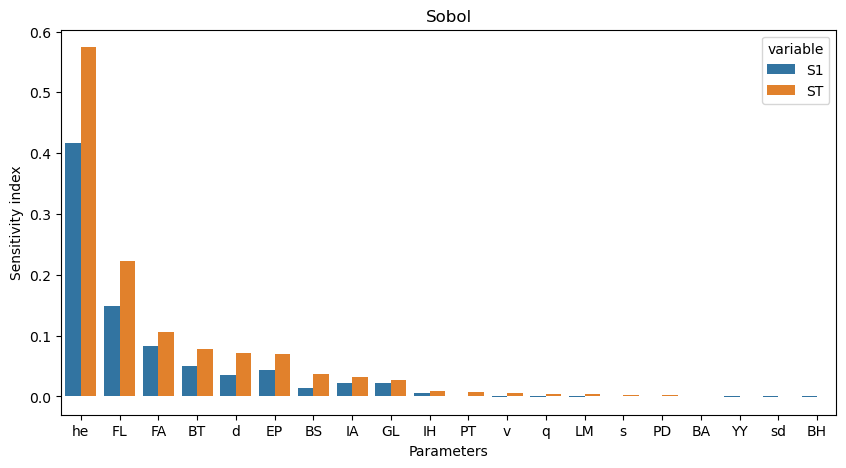

In [78]:
df = pd.concat([ST, S1], axis=1)
df = df.reset_index()
df = df.sort_values("ST", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=df.melt(id_vars="index", value_vars=["S1", "ST"]),
    x="index", y="value", hue="variable", ax=ax
)
ax.set_xlabel("Parameters")
ax.set_ylabel("Sensitivity index")
ax.set_title("Sobol")
# plt.savefig("figures/all", bbox_inches='tight')
plt.show()

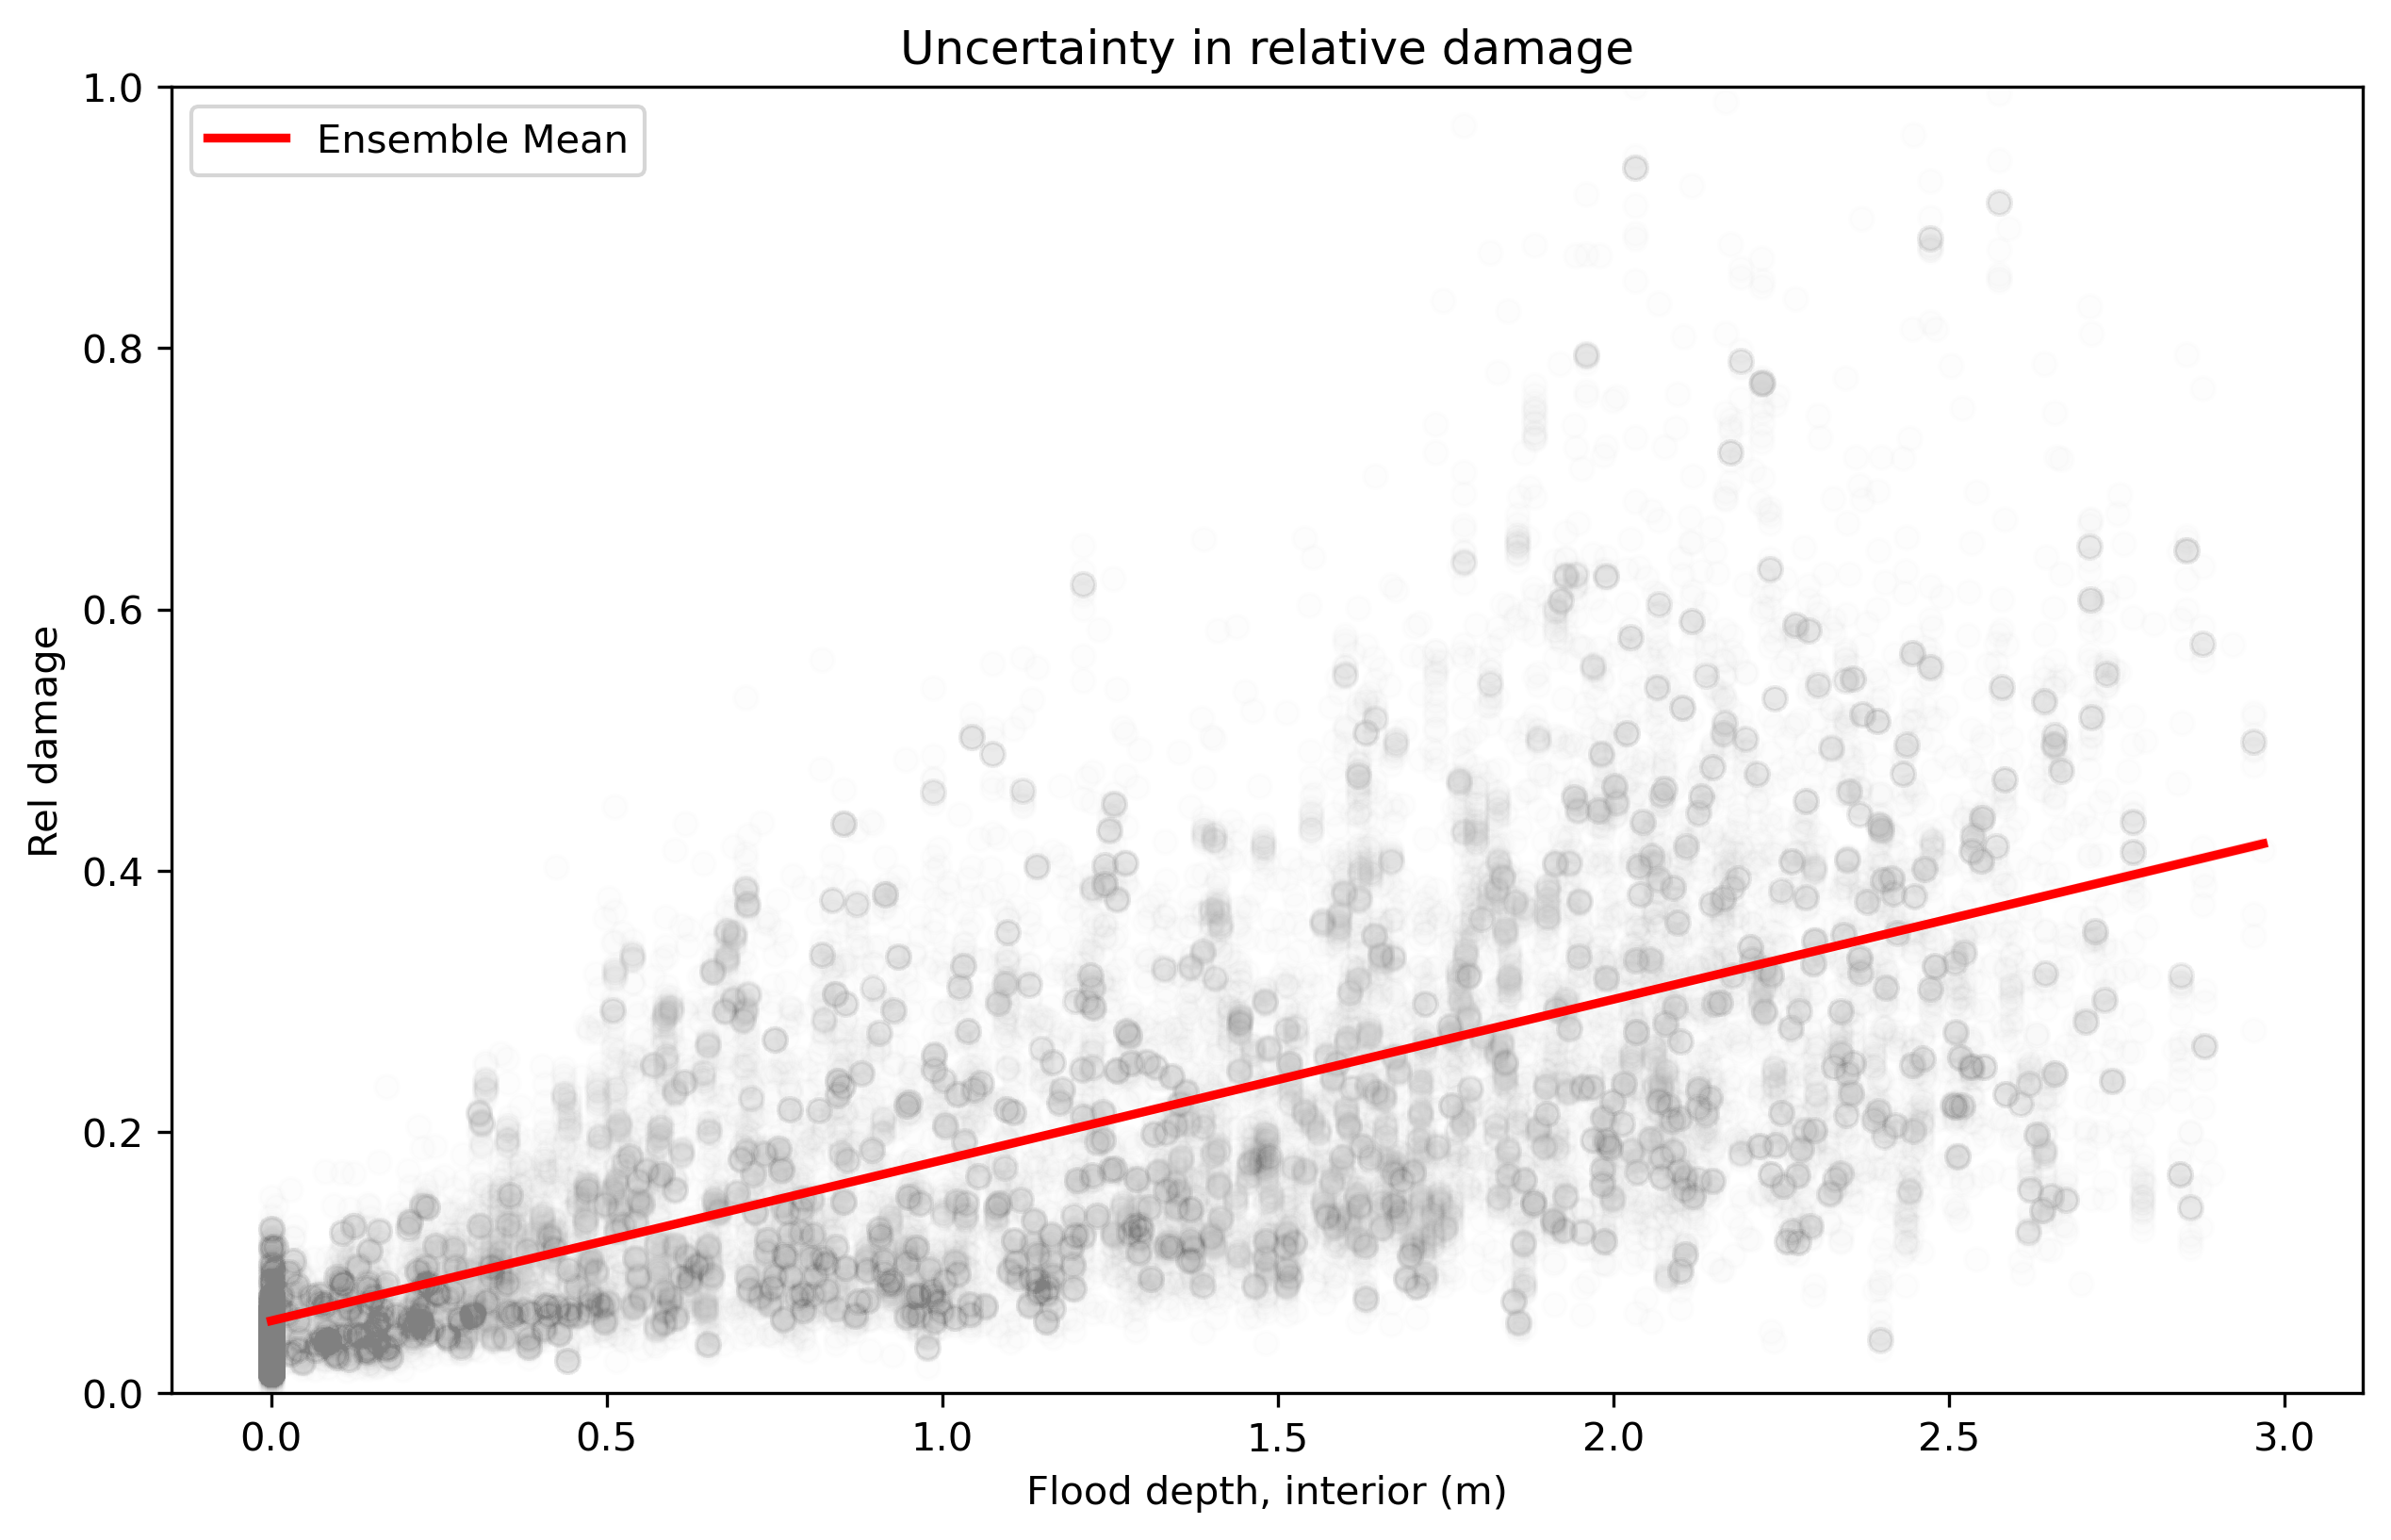

In [74]:
# Can plot damage function from ensemble
temp = pd.DataFrame(pd.concat([pd.Series(depth, name='depth'),
                               pd.Series(damage, name='rel_dam')], axis=1))

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

sns.regplot(data=temp,
            x='depth',
            y='rel_dam',
            scatter=False,
            line_kws=dict(color="r"),
            label='Ensemble Mean',
            ax=ax)

ax.scatter(depth, damage, alpha=0.01, color='gray')
ax.set_xlabel('Flood depth, interior (m)')
ax.set_ylabel('Rel damage')
ax.set_title('Uncertainty in relative damage')
ax.set_ylim(0, 1) # cheating ?
ax.legend()

We can also compare uncertainty in expert-based damage functions to our ensemble

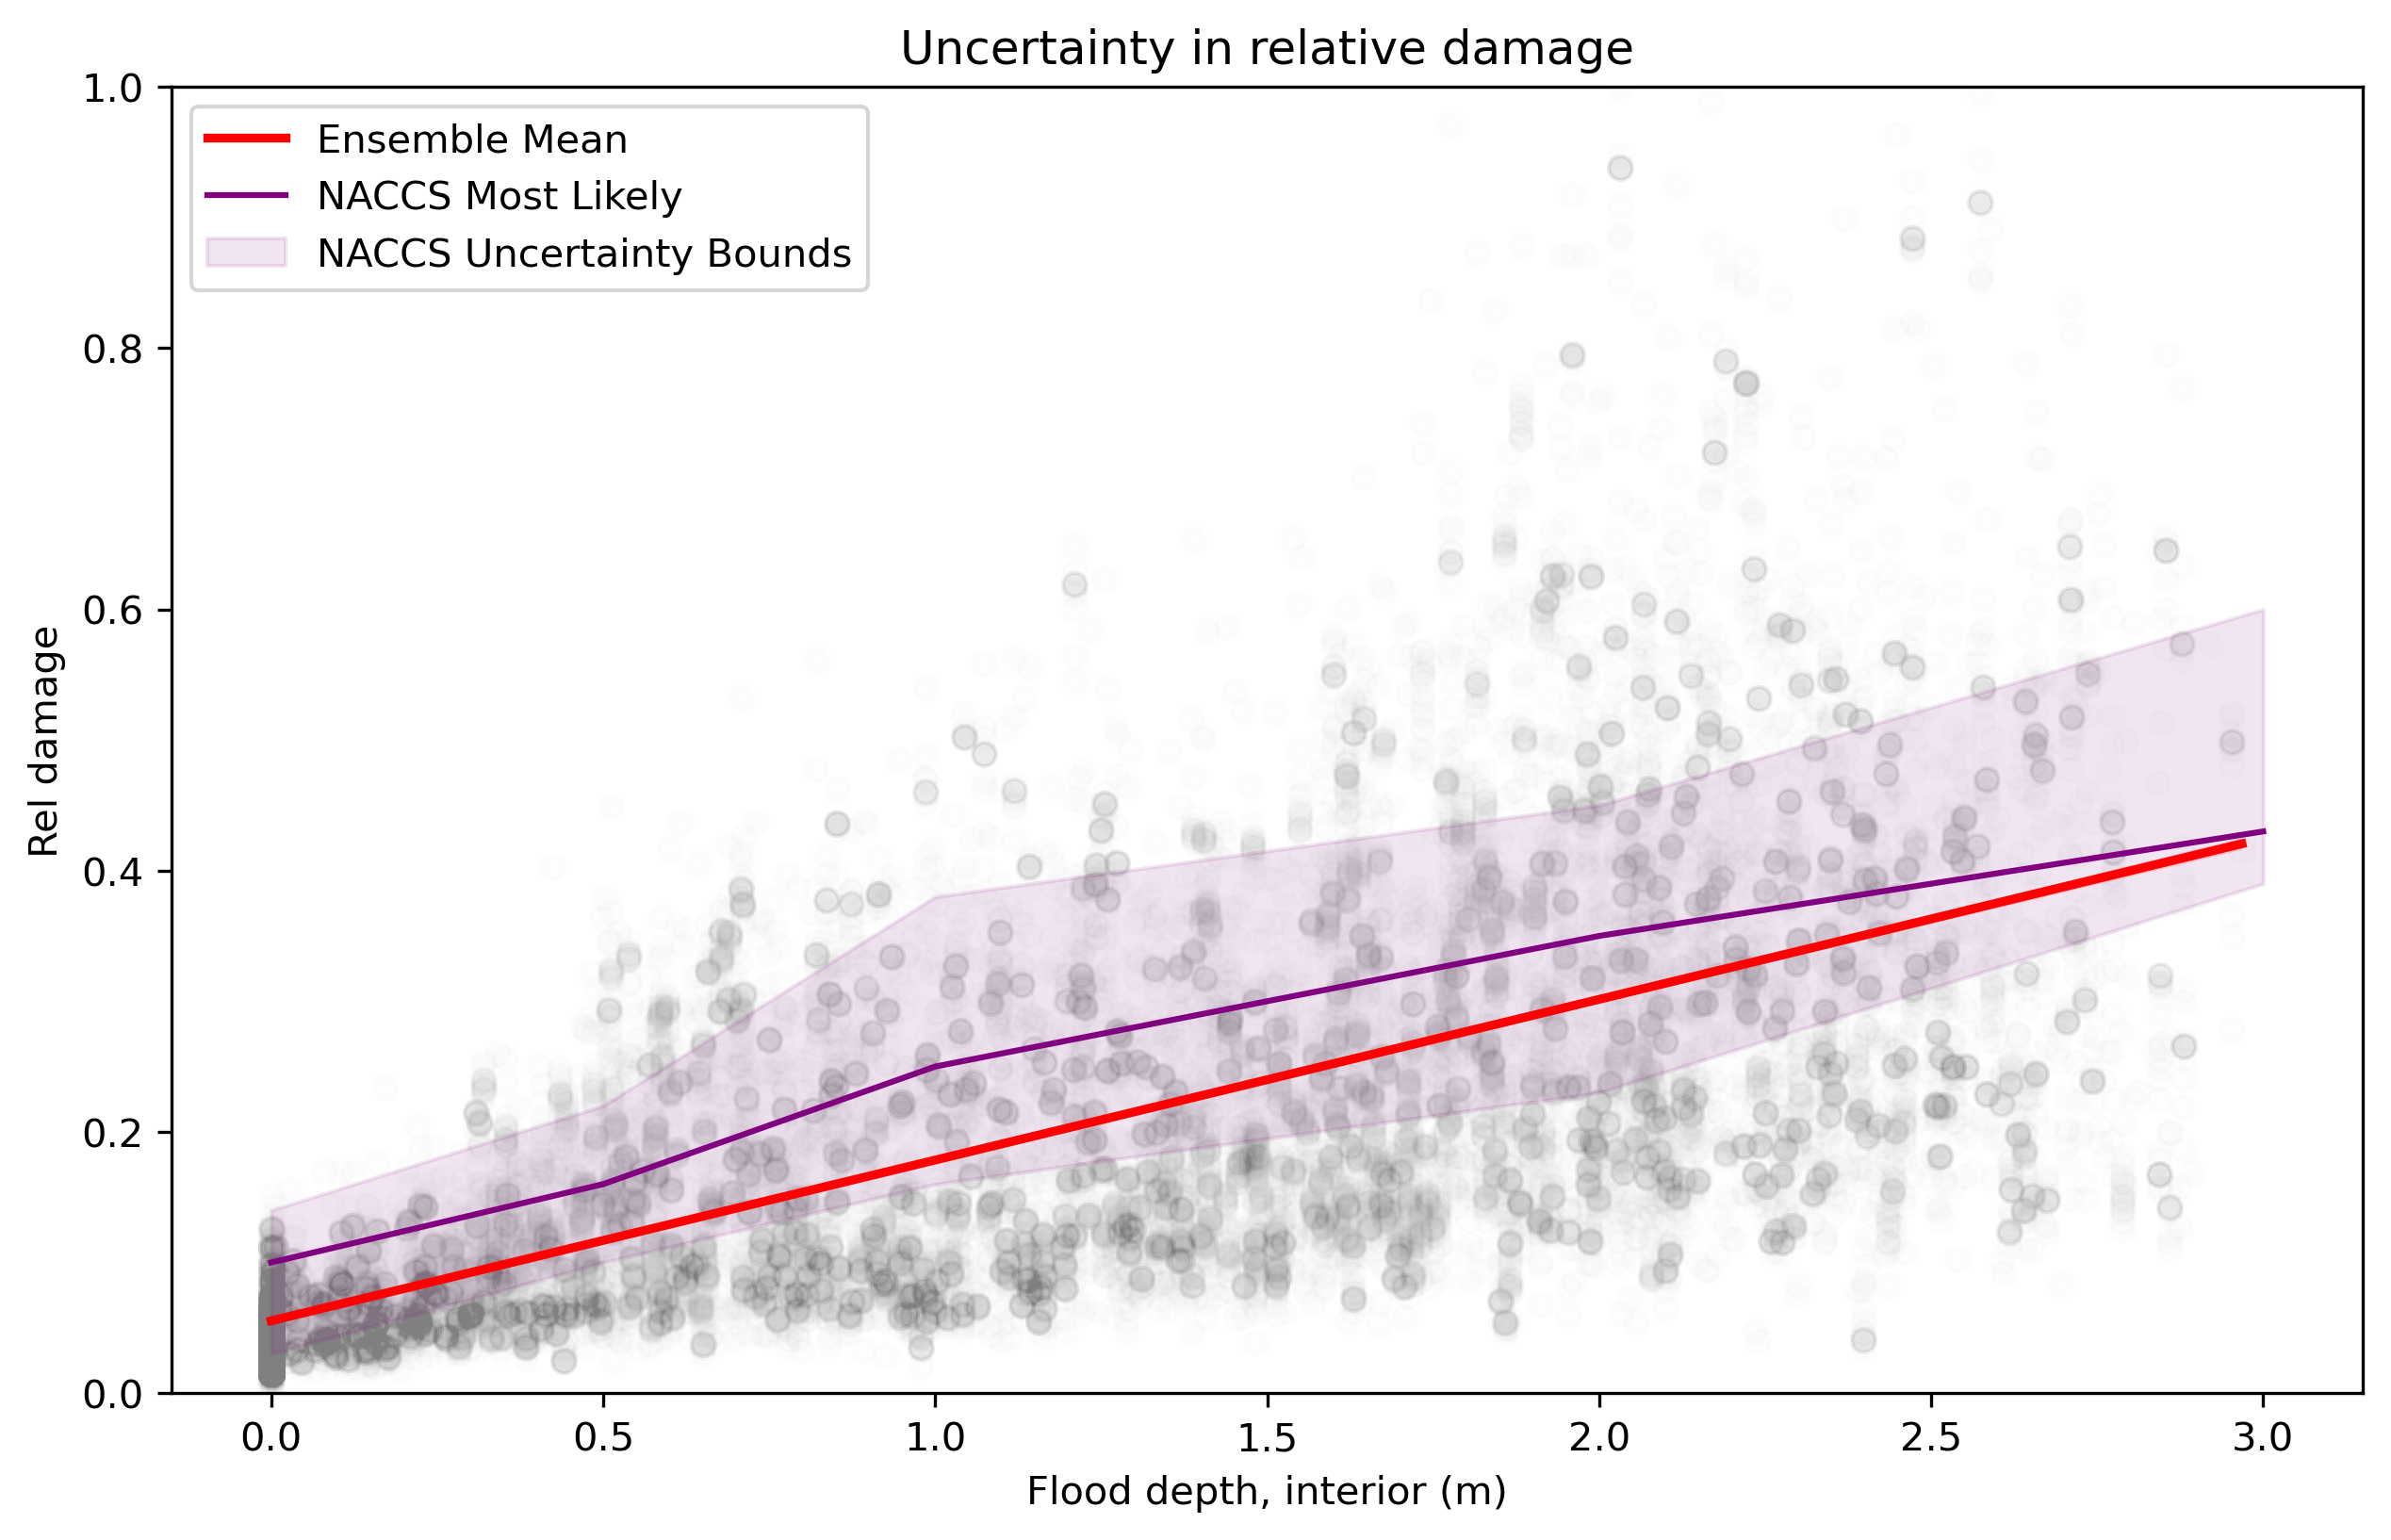

In [77]:
naccs = {
    "Flood Depth (m)": [-1.0, -0.5, 0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0],
    "Min": [0, 0, .03, .10, .16, .23, .39, .52, .59],
    "Most Likely": [0, 0, .10, .16, .25, .35, .43, .60, .68],
    "Max": [0, 0, .14, .22, .38, .45, .60, .75, .85]
}

df = pd.DataFrame(naccs)

interp_range = np.linspace(0, 3, 25)
most_interp = np.interp(interp_range, df["Flood Depth (m)"], df["Most Likely"])
min_interp = np.interp(interp_range, df["Flood Depth (m)"], df["Min"])
max_interp = np.interp(interp_range, df["Flood Depth (m)"], df["Max"])

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

sns.regplot(data=temp,
            x='depth',
            y='rel_dam',
            scatter=False,
            line_kws=dict(color="r"),
            label='Ensemble Mean',
            ax=ax)

ax.scatter(depth, damage, alpha=0.01, color='gray')
ax.set_xlabel('Flood depth, interior (m)')
ax.set_ylabel('Rel damage')
ax.set_title('Uncertainty in relative damage')
ax.set_ylim(0, 1) # cheating ?

ax.plot(interp_range, most_interp, label='NACCS Most Likely', linestyle='-', 
        color="purple")
ax.fill_between(interp_range, min_interp, max_interp, color='purple', alpha=.1,
                label='NACCS Uncertainty Bounds')
ax.legend()

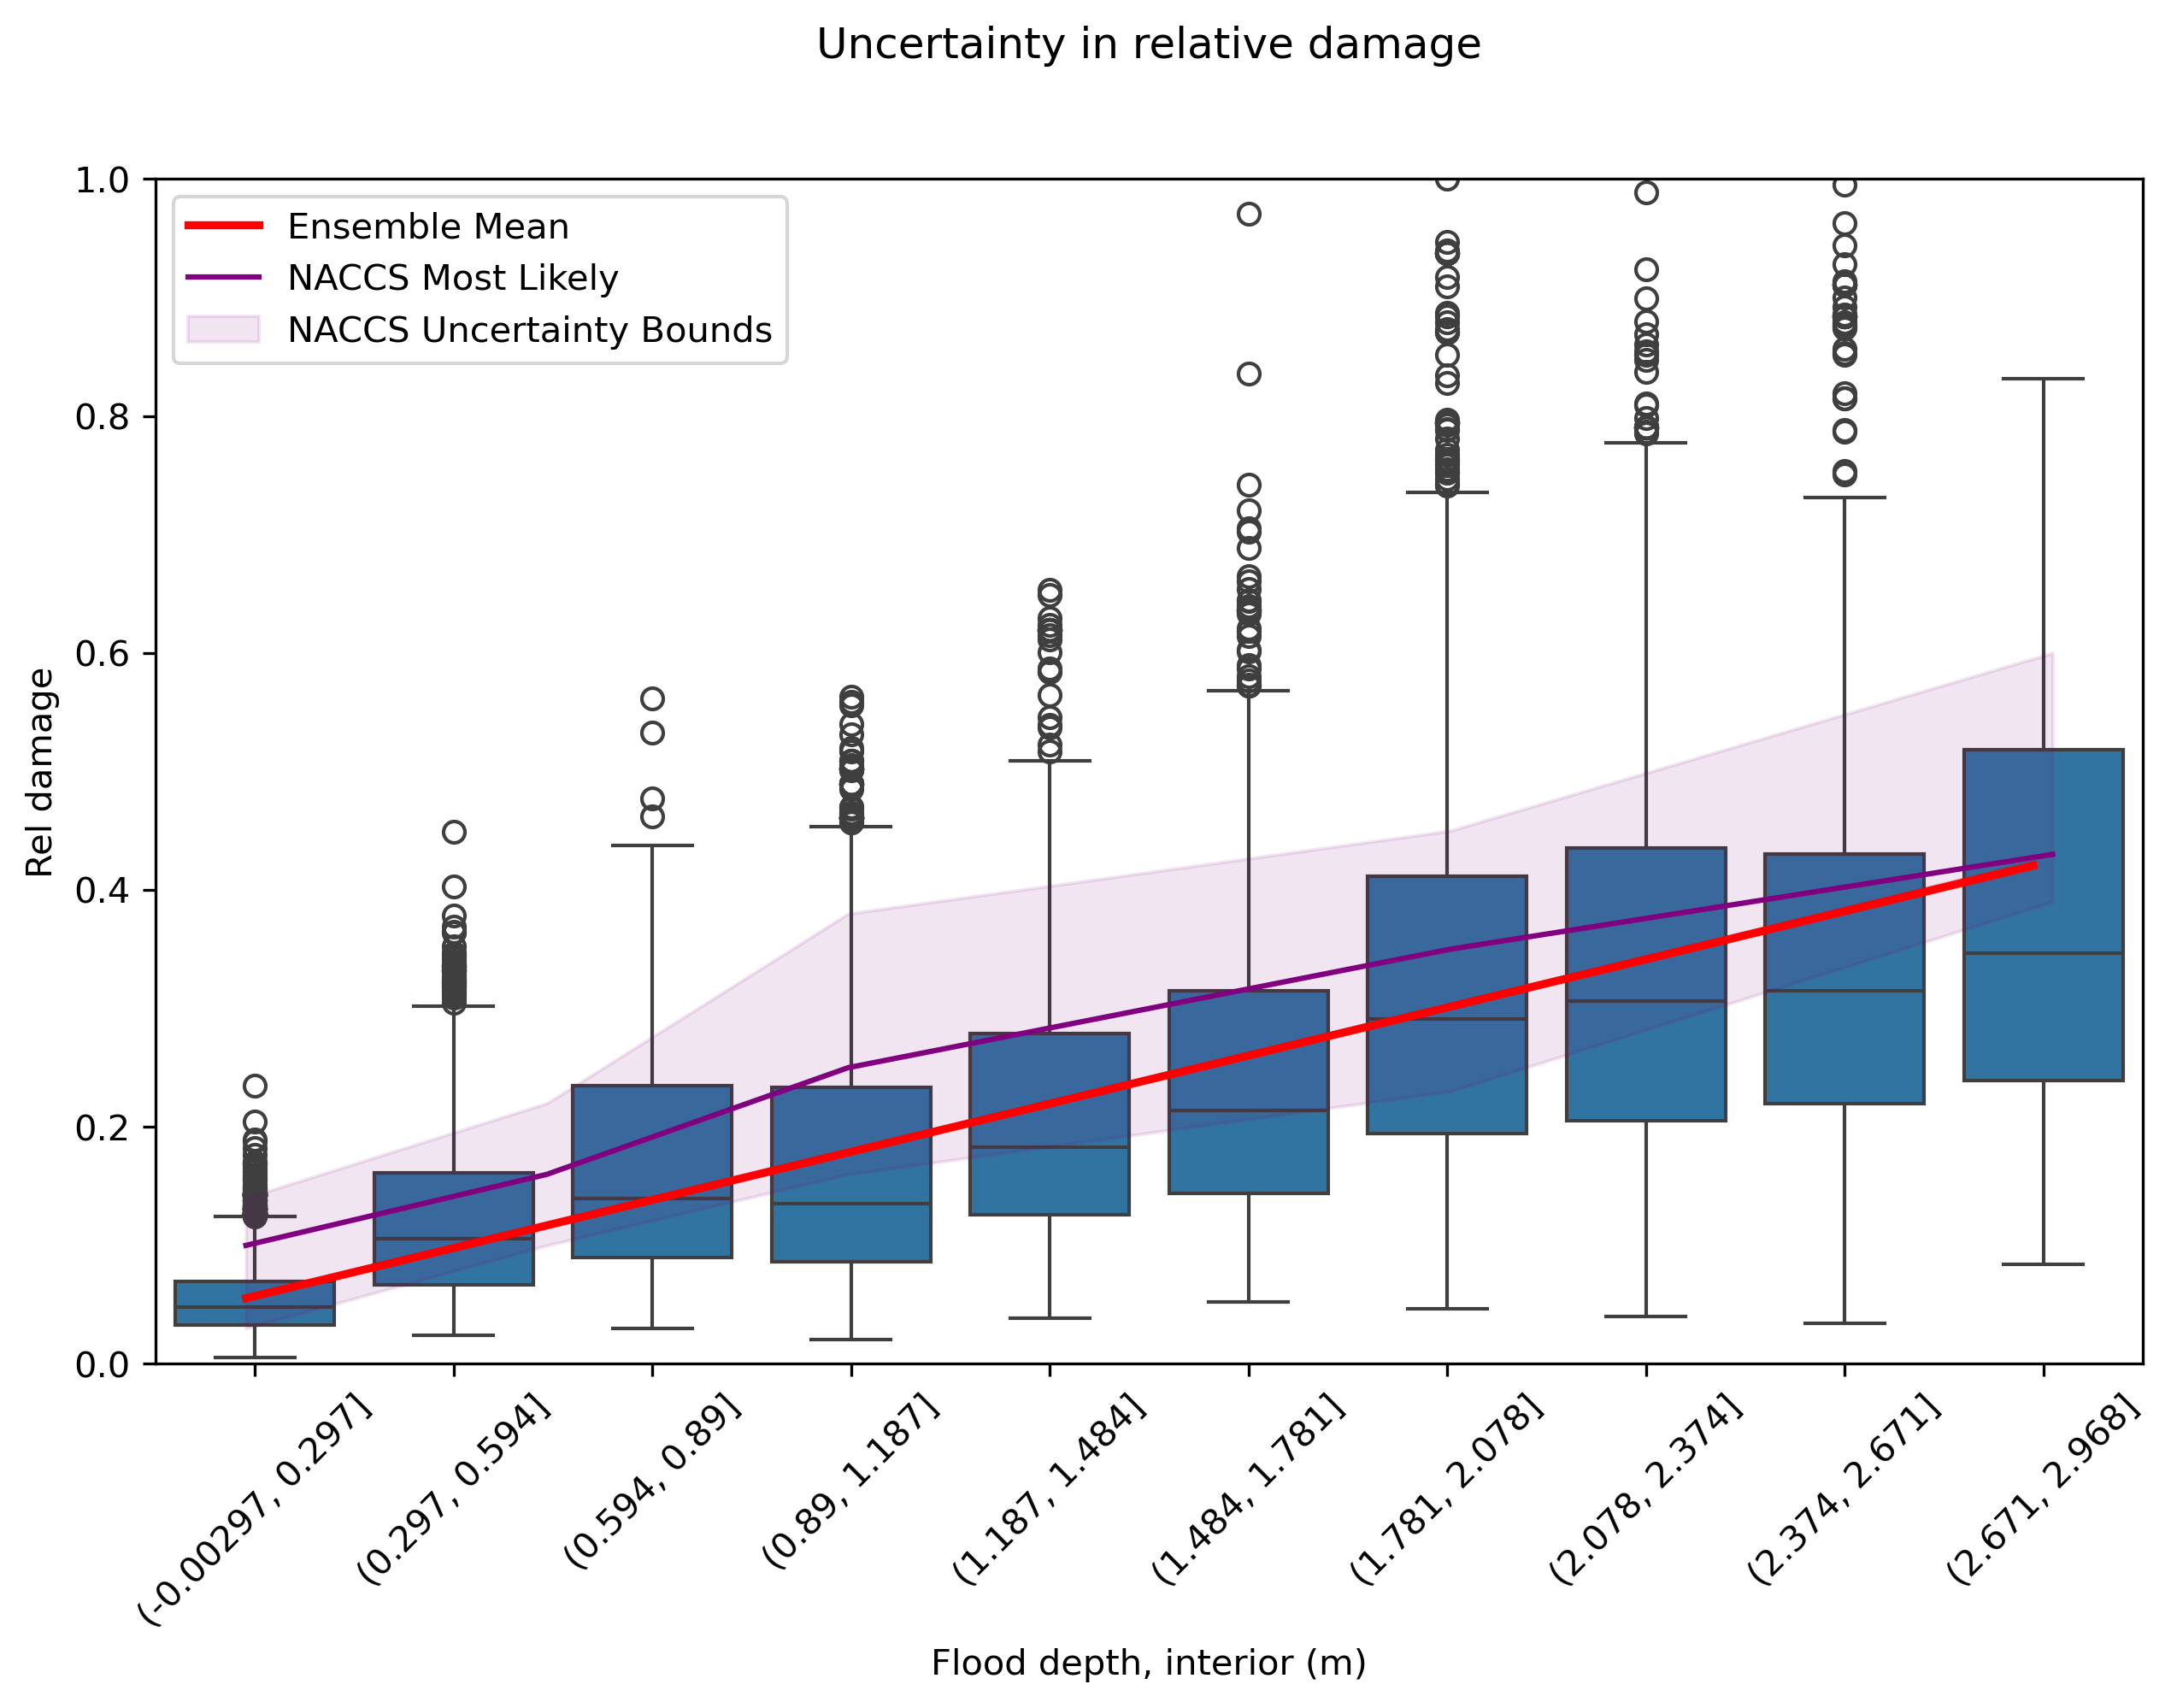

In [95]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax2 = ax.twiny()
ax2.axis('off')

sns.boxplot(temp,
            x='d_bins',
            y='rel_dam',
            ax=ax)

sns.regplot(data=temp,
            x='depth',
            y='rel_dam',
            scatter=False,
            line_kws=dict(color="r"),
            label='Ensemble Mean',
            ax=ax2)

# Replace scatterplot with boxplots
temp['d_bins'] = pd.cut(temp['depth'], bins=10)

ax.set_xlabel('Flood depth, interior (m)')
ax.set_ylabel('Rel damage')
ax.set_title('Uncertainty in relative damage')
ax.set_ylim(0, 1) # cheating ?
ax.tick_params('x', rotation=45)

ax2.plot(interp_range, most_interp, label='NACCS Most Likely', linestyle='-', 
        color="purple")
ax2.fill_between(interp_range, min_interp, max_interp, color='purple', alpha=.1,
                label='NACCS Uncertainty Bounds')
ax2.legend(loc='upper left')